In [22]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### load in and normalize the dataset
dataset = pd.read_csv('IBM.csv')

In [23]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-04-30,206.710007,207.960007,206.320007,207.080002,171.139999,2773200
1,2012-05-01,207.179993,208.929993,206.710007,208.000000,171.900360,2715900
2,2012-05-02,206.970001,208.270004,206.910004,208.059998,171.949890,2360300
3,2012-05-03,208.270004,208.919998,206.550003,207.240005,171.272232,2826600
4,2012-05-04,206.470001,207.110001,204.399994,204.990005,169.412750,4023600


In [24]:
col_list = dataset.columns.tolist()
col_list

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [25]:
col_list.remove('Close')
col_list.remove('Date')
col_list.append('Close')
col_list

['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Close']

In [26]:
df = dataset[col_list]
df.head()

,Open,High,Low,Adj Close,Volume,Close
0,206.710007,207.960007,206.320007,171.139999,2773200,207.080002
1,207.179993,208.929993,206.710007,171.900360,2715900,208.000000
2,206.970001,208.270004,206.910004,171.949890,2360300,208.059998
3,208.270004,208.919998,206.550003,171.272232,2826600,207.240005
4,206.470001,207.110001,204.399994,169.412750,4023600,204.990005


In [27]:
df['Volume'] = df['Volume'] / 1000000
df.head()

C:\Users\Vrun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Adj Close,Volume,Close
0,206.710007,207.960007,206.320007,171.139999,2.7732,207.080002
1,207.179993,208.929993,206.710007,171.900360,2.7159,208.000000
2,206.970001,208.270004,206.910004,171.949890,2.3603,208.059998
3,208.270004,208.919998,206.550003,171.272232,2.8266,207.240005
4,206.470001,207.110001,204.399994,169.412750,4.0236,204.990005


In [28]:
import  time
import  math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep

In [29]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [30]:
def preprocess_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix()
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [36]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [37]:
window =  20
X_train, y_train, X_test, y_test = preprocess_data(df[:: -1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1339, 20, 6)
y_train (1339,)
X_test (149, 20, 6)
y_test (149,)


In [38]:
model = build_model([X_train.shape[2], window, 100, 1])

C:\Users\Vrun\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
C:\Users\Vrun\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 6), units=20)`
  
C:\Users\Vrun\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Compilation Time :  0.43654775619506836


In [39]:
model.fit(
    X_train,
    y_train,
    batch_size=768,
    nb_epoch=300,
    validation_split=0.1,
    verbose=0)

C:\Users\Vrun\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [40]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.01 MSE (0.12 RMSE)
Test Score: 0.03 MSE (0.16 RMSE)


In [41]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

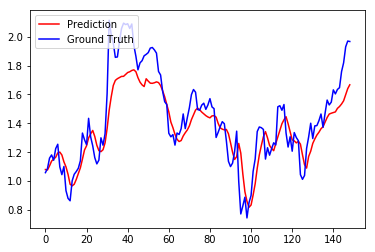

In [42]:
import  matplotlib.pyplot  as plt2

plt2.plot(pred, color='red', label='Prediction')
plt2.plot(y_test, color='blue', label='Ground Truth')
plt2.legend(loc='upper left')
plt2.show()